In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import os
import random
from torch.autograd import Variable
import copy
from torch import nn, optim
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import csv
import time
import math


In [2]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
fix_seed(SEED)

In [3]:
class Argments():
  def __init__(self):
    self.batch_size = 40
    self.test_batch = 1000
    self.global_epochs = 500
    self.local_epochs = 2
    self.lr = None
    self.momentum = 0.9
    self.weight_decay = 10**-4.0
    self.clip = 20.0
    self.partience = 500
    self.worker_num = 20
    self.sample_num = 20
    self.unlabeleddata_size = 1000
    self.device = torch.device('cuda:0'if torch.cuda.is_available() else'cpu')
    self.criterion = nn.CrossEntropyLoss()
    
    self.alpha_label = 0.5
    self.alpha_size = 10

args = Argments()

In [4]:
lr = 0

In [6]:
lr_list = []
lr_list.append(10**-3.0)
lr_list.append(10**-2.5)
lr_list.append(10**-2.0)
lr_list.append(10**-1.5)
lr_list.append(10**-1.0)
lr_list.append(10**-0.5)
lr_list.append(10**0.0)
lr_list.append(10**0.5)

args.lr = lr_list[lr]

In [9]:
class LocalDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.data = []
        self.label = []

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]
        if self.transform:
            out_data = self.transform(out_data)
        return out_data, out_label
    
class DatasetFromSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)
    
class GlobalDataset(torch.utils.data.Dataset):
  def __init__(self,federated_dataset,transform=None):
    self.transform = transform
    self.data = []
    self.label = []
    for dataset in federated_dataset:
      for (data,label) in dataset:
        self.data.append(data)
        self.label.append(label)

  def __getitem__(self, idx):
    out_data = self.data[idx]
    out_label = self.label[idx]
    if self.transform:
        out_data = self.transform(out_data)
    return out_data, out_label

  def __len__(self):
    return len(self.data)

class UnlabeledDataset(torch.utils.data.Dataset):
  def __init__(self,transform=None):
    self.transform = transform
    self.data = []
    self.target = None

  def __getitem__(self, idx):
    out_data = self.data[idx]
    out_label = 'unlabeled'
    if self.transform:
        out_data = self.transform(out_data)
    return out_data, out_label

  def __len__(self):
    return len(self.data)

In [10]:
def get_dataset(Centralized=False,unlabeled_data=False):
    
    transform_train = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomCrop(32, padding=2),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.491372549, 0.482352941, 0.446666667), (0.247058824, 0.243529412, 0.261568627))])
    transform_test = transforms.Compose([transforms.ToPILImage(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.491372549, 0.482352941, 0.446666667), (0.247058824, 0.243529412, 0.261568627))])

    # download train data
    all_trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True)
    #trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

    # download test data
    all_testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True)
    #testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

    
    ## get unlabeled dataset
    if unlabeled_data:
        unlabeled_dataset = UnlabeledDataset(transform_test)
        idx = sorted(random.sample(range(len(all_trainset)),args.unlabeleddata_size))
        unlabeled_dataset.data = np.array([all_trainset.data[i]  for i in idx])
        all_trainset.data = np.delete(all_trainset.data,idx,0)
        all_trainset.targets = np.delete(all_trainset.targets,idx,0)
    all_train_data = np.array(all_trainset.data)
    all_train_label = np.array(all_trainset.targets)
    all_test_data = np.array(all_testset.data)
    all_test_label = np.array(all_testset.targets)
    print('Train:{} Test:{}'.format(len(all_train_data),len(all_test_data)))


    ## Data size heterogeneity
    data_proportions = np.random.dirichlet(np.repeat(args.alpha_size, args.worker_num))
    train_data_proportions = np.array([0 for _ in range(args.worker_num)])
    test_data_proportions = np.array([0 for _ in range(args.worker_num)])
    for i in range(len(data_proportions)):
        if i==(len(data_proportions)-1):
            train_data_proportions = train_data_proportions.astype('int64')
            test_data_proportions = test_data_proportions.astype('int64')
            train_data_proportions[-1] = len(all_train_data) - np.sum(train_data_proportions[:-1])
            test_data_proportions[-1] = len(all_test_data) - np.sum(test_data_proportions[:-1])
        else:
            train_data_proportions[i] = (data_proportions[i] * len(all_train_data))
            test_data_proportions[i] = (data_proportions[i] * len(all_test_data))
    min_size = 0
    K = 10

    '''
    label_list = np.arange(10)
    np.random.shuffle(label_list)
    '''
    label_list = list(range(K))


    ## Data distribution heterogeneity
    while min_size<10:
        idx_train_batch = [[] for _ in range(args.worker_num)]
        idx_test_batch = [[] for _ in range(args.worker_num)]
        for k in label_list:
            proportions_train = np.random.dirichlet(np.repeat(args.alpha_label, args.worker_num))
            proportions_test = copy.deepcopy(proportions_train)
            idx_k_train = np.where(all_train_label == k)[0]
            idx_k_test = np.where(all_test_label == k)[0]
            np.random.shuffle(idx_k_train)
            np.random.shuffle(idx_k_test)
            ## Balance (train)
            proportions_train = np.array([p*(len(idx_j)<train_data_proportions[i]) for i,(p,idx_j) in enumerate(zip(proportions_train,idx_train_batch))])
            proportions_train = proportions_train/proportions_train.sum()
            proportions_train = (np.cumsum(proportions_train)*len(idx_k_train)).astype(int)[:-1]
            idx_train_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_train_batch,np.split(idx_k_train,proportions_train))]

            ## Balance (test)
            proportions_test = np.array([p*(len(idx_j)<test_data_proportions[i]) for i,(p,idx_j) in enumerate(zip(proportions_test,idx_test_batch))])
            proportions_test = proportions_test/proportions_test.sum()
            proportions_test = (np.cumsum(proportions_test)*len(idx_k_test)).astype(int)[:-1]
            idx_test_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_test_batch,np.split(idx_k_test,proportions_test))]

            min_size = min([len(idx_j) for idx_j in idx_train_batch])

    federated_trainset = []
    federated_testset = []
    for i in range(args.worker_num):
        ## create trainset
        data = [all_train_data[idx] for idx in idx_train_batch[i]]
        label = [all_train_label[idx] for idx in idx_train_batch[i]]
        federated_trainset.append(LocalDataset())
        federated_trainset[-1].data = data
        federated_trainset[-1].label = label

        ## create testset
        data = [all_test_data[idx] for idx in idx_test_batch[i]]
        label = [all_test_label[idx] for idx in idx_test_batch[i]]
        federated_testset.append(LocalDataset())
        federated_testset[-1].data = data
        federated_testset[-1].label = label

        
    ## split trainset
    federated_valset = [None]*args.worker_num
    for i in range(args.worker_num):
        n_samples = len(federated_trainset[i])
        if n_samples==1:
            train_subset = federated_trainset[i]
            val_subset = copy.deepcopy(federated_trainset[i])
        else:
            train_size = int(len(federated_trainset[i]) * 0.8) 
            val_size = n_samples - train_size 
            train_subset,val_subset = torch.utils.data.random_split(federated_trainset[i], [train_size, val_size])

        federated_trainset[i] = DatasetFromSubset(train_subset)
        federated_valset[i] = DatasetFromSubset(val_subset)

    ## show data distribution
    H = 4
    W = 5
    fig, axs = plt.subplots(H, W, figsize=(20, 5))
    x = np.arange(1,11)
    for i, (trainset,valset,testset) in enumerate(zip(federated_trainset,federated_valset,federated_testset)):
        bottom = [0]*10
        count = [0]*10
        for _,label in trainset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        for j in range(len(count)):
            bottom[j]+=count[j]
        count = [0]*10
        for _,label in valset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        for j in range(len(count)):
            bottom[j]+=count[j]
        count = [0]*10
        for _,label in testset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        #axs[int(i/W), i%W].title("worker{}".format(i+1), fontsize=12, color = "green")

    plt.show()

    ## get global dataset
    if Centralized:
        global_trainset = GlobalDataset(federated_trainset)
        global_valset = GlobalDataset(federated_valset)
        global_testset =  GlobalDataset(federated_testset)
        
        #show_cifer(global_trainset.data,global_testset.label, cifar10_labels)

        global_trainset.transform = transform_train
        global_valset.transform = transform_test
        global_testset.transform = transform_test

        global_trainloader = torch.utils.data.DataLoader(global_trainset,batch_size=args.batch_size,shuffle=True,num_workers=2)
        global_valloader = torch.utils.data.DataLoader(global_valset,batch_size=args.test_batch,shuffle=False,num_workers=2)
        global_testloader = torch.utils.data.DataLoader(global_testset,batch_size=args.test_batch,shuffle=False,num_workers=2)

    ## set transform
    for i in range(args.worker_num):
        federated_trainset[i].transform = transform_train
        federated_valset[i].transform = transform_test
        federated_testset[i].transform = transform_test
    
    if Centralized and unlabeled_data:
        return federated_trainset,federated_valset,federated_testset,global_trainloader,global_valloader,global_testloader,unlabeled_dataset
    if Centralized:
        return federated_trainset,federated_valset,federated_testset,global_trainloader,global_valloader,global_testloader
    elif unlabeled_data:
        return federated_trainset,federated_valset,federated_testset,unlabeled_dataset
    else:
        return federated_trainset,federated_valset,federated_testset

Files already downloaded and verified
Files already downloaded and verified
Train:49000 Test:10000


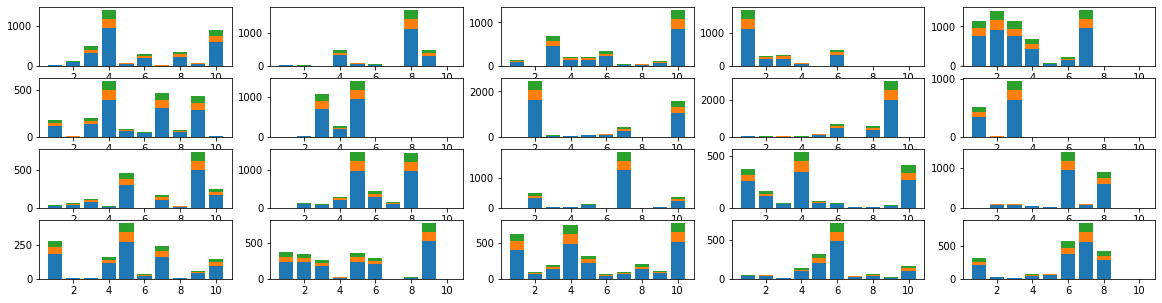

In [11]:
federated_trainset,federated_valset,federated_testset,unlabeled_dataset = get_dataset(unlabeled_data=True)

In [12]:
total = [0,0,0]
for i in range(args.worker_num):
    total[0]+=len(federated_trainset[i])
    total[1]+=len(federated_valset[i])
    total[2]+=len(federated_testset[i])
print(total)

[39191, 9809, 10000]


In [14]:
class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            #print("in_channels: {}, v: {}".format(in_channels, v))
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}


class VGGConvBlocks(nn.Module):
    '''
    VGG containers that only contains the conv layers 
    '''
    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

class VGGContainer(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features, input_dim, hidden_dims, num_classes=10):
        super(VGGContainer, self).__init__()
        self.features = features
        # note: we hard coded here a bit by assuming we only have two hidden layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(True),
            nn.Linear(hidden_dims[1], num_classes),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def matched_vgg11(matched_shapes):
    # [(67, 27), (67,), (132, 603), (132,), (260, 1188), (260,), (261, 2340), (261,), (516, 2349), (516,), (517, 4644), (517,), 
    # (516, 4653), (516,), (516, 4644), (516,), (516, 515), (515,), (515, 515), (515,), (515, 10), (10,)]
    processed_matched_shape = [matched_shapes[0][0], 
                                'M', 
                                matched_shapes[2][0], 
                                'M', 
                                matched_shapes[4][0], 
                                matched_shapes[6][0], 
                                'M', 
                                matched_shapes[8][0], 
                                matched_shapes[10][0], 
                                'M', 
                                matched_shapes[12][0], 
                                matched_shapes[14][0], 
                                'M']
    return VGGContainer(make_layers(processed_matched_shape), input_dim=matched_shapes[16][0], 
            hidden_dims=[matched_shapes[16][1], matched_shapes[18][1]], num_classes=10)


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn(num_classes=10):
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True), num_classes=num_classes)


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

In [15]:
class Server():
  def __init__(self):
    self.model = vgg13()

  def create_worker(self,federated_trainset,federated_valset,federated_testset):
    workers = []
    for i in range(args.worker_num):
      workers.append(Worker(federated_trainset[i],federated_valset[i],federated_testset[i]))
    return workers

  def sample_worker(self,workers):
    sample_worker = []
    sample_worker_num = random.sample(range(args.worker_num),args.sample_num)
    for i in sample_worker_num:
      sample_worker.append(workers[i])
    return sample_worker


  def send_model(self,workers):
    nums = 0
    for worker in workers:
      nums += worker.train_data_num

    for worker in workers:
      worker.aggregation_weight = 1.0*worker.train_data_num/nums
      worker.model = copy.deepcopy(self.model)
      worker.model = worker.model.to(args.device)

  def aggregate_model(self,workers):   
    new_params = OrderedDict()
    for i,worker in enumerate(workers):
      worker_state = worker.model.state_dict()
      for key in worker_state.keys():
        if i==0:
          new_params[key] = worker_state[key]*worker.aggregation_weight
        else:
          new_params[key] += worker_state[key]*worker.aggregation_weight
      worker.model = worker.model.to('cpu')
      del worker.model
    self.model.load_state_dict(new_params)

In [16]:
class Worker():
  def __init__(self,trainset,valset,testset):
    self.trainloader = torch.utils.data.DataLoader(trainset,batch_size=args.batch_size,shuffle=True,num_workers=2)
    self.valloader = torch.utils.data.DataLoader(valset,batch_size=args.test_batch,shuffle=False,num_workers=2)
    self.testloader = torch.utils.data.DataLoader(testset,batch_size=args.test_batch,shuffle=False,num_workers=2)
    self.model = None
    self.train_data_num = len(trainset)
    self.test_data_num = len(testset)
    self.aggregation_weight = None

  def local_train(self):
    acc_train,loss_train = train(self.model,args.criterion,self.trainloader,args.local_epochs)
    acc_valid,loss_valid = test(self.model,args.criterion,self.valloader)
    return acc_train,loss_train,acc_valid,loss_valid

    

In [17]:
def train(model,criterion,trainloader,epochs):
  optimizer = optim.SGD(model.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay)
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    count = 0
    for (data,labels) in trainloader:
      data,labels = Variable(data),Variable(labels)
      data,labels = data.to(args.device),labels.to(args.device)
      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs,labels)
      running_loss += loss.item()
      predicted = torch.argmax(outputs,dim=1)
      correct += (predicted==labels).sum().item()
      count += len(labels)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
      optimizer.step()

  return 100.0*correct/count,running_loss/len(trainloader)



In [18]:
def test(model,criterion,testloader):
  model.eval()
  running_loss = 0.0
  correct = 0
  count = 0
  for (data,labels) in testloader:
    data,labels = data.to(args.device),labels.to(args.device)
    outputs = model(data)
    running_loss += criterion(outputs,labels).item()
    predicted = torch.argmax(outputs,dim=1)
    correct += (predicted==labels).sum().item()
    count += len(labels)

  accuracy = 100.0*correct/count
  loss = running_loss/len(testloader)


  return accuracy,loss

In [19]:
class Early_Stopping():
  def __init__(self,partience):
    self.step = 0
    self.loss = float('inf')
    self.partience = partience

  def validate(self,loss):
    if self.loss<loss:
      self.step += 1
      if self.step>self.partience:
        return True
    else:
      self.step = 0
      self.loss = loss

    return False

In [20]:
server = Server()
workers = server.create_worker(federated_trainset,federated_valset,federated_testset)
acc_train = []
loss_train = []
acc_valid = []
loss_valid = []

early_stopping = Early_Stopping(args.partience)

start = time.time()

for epoch in range(args.global_epochs):
  sample_worker = server.sample_worker(workers)
  server.send_model(sample_worker)

  acc_train_avg = 0.0
  loss_train_avg = 0.0
  acc_valid_avg = 0.0
  loss_valid_avg = 0.0
  for worker in sample_worker:
    acc_train_tmp,loss_train_tmp,acc_valid_tmp,loss_valid_tmp = worker.local_train()
    acc_train_avg += acc_train_tmp/len(sample_worker)
    loss_train_avg += loss_train_tmp/len(sample_worker)
    acc_valid_avg += acc_valid_tmp/len(sample_worker)
    loss_valid_avg += loss_valid_tmp/len(sample_worker)
  server.aggregate_model(sample_worker)
  '''
  server.model.to(args.device)
  for worker in workers:
    acc_valid_tmp,loss_valid_tmp = test(server.model,args.criterion,worker.valloader)
    acc_valid_avg += acc_valid_tmp/len(workers)
    loss_valid_avg += loss_valid_tmp/len(workers)
  server.model.to('cpu')
  '''
  print('Epoch{}  loss:{}  accuracy:{}'.format(epoch+1,loss_valid_avg,acc_valid_avg))
  acc_train.append(acc_train_avg)
  loss_train.append(loss_train_avg)
  acc_valid.append(acc_valid_avg)
  loss_valid.append(loss_valid_avg)

  if early_stopping.validate(loss_valid_avg):
    print('Early Stop')
    break
    
end = time.time()

Epoch1  loss:1.633384159207344  accuracy:43.38342688191277
Epoch2  loss:1.4930766344070436  accuracy:43.82718161572266
Epoch3  loss:1.480247959494591  accuracy:42.858551986235156
Epoch4  loss:1.4766689777374267  accuracy:43.04309314379103
Epoch5  loss:1.4640475332736969  accuracy:44.10558747240963
Epoch6  loss:1.452163538336754  accuracy:44.13413078035386
Epoch7  loss:1.4299251973629001  accuracy:45.544231823382596
Epoch8  loss:1.3824883431196213  accuracy:49.887734600964336
Epoch9  loss:1.3104586631059645  accuracy:52.942558772617254
Epoch10  loss:1.2677022218704221  accuracy:53.71332201611844
Epoch11  loss:1.2553341686725619  accuracy:54.42367849526681
Epoch12  loss:1.2256717711687086  accuracy:54.46792277433714
Epoch13  loss:1.193456906080246  accuracy:56.17340841584055
Epoch14  loss:1.174005052447319  accuracy:56.159464337523374
Epoch15  loss:1.1834368079900741  accuracy:56.40479237576704
Epoch16  loss:1.1620809316635132  accuracy:57.50562703852613
Epoch17  loss:1.1603864997625353 

Epoch136  loss:0.5796826533973217  accuracy:80.53007859339654
Epoch137  loss:0.5856906823813914  accuracy:79.65144840765711
Epoch138  loss:0.5534596875309944  accuracy:80.74866704596833
Epoch139  loss:0.5669529892504214  accuracy:80.49892323090884
Epoch140  loss:0.5609595589339734  accuracy:81.45782055394514
Epoch141  loss:0.5606307744979858  accuracy:80.76451924095167
Epoch142  loss:0.5634394310414791  accuracy:80.82244028038639
Epoch143  loss:0.5642015404999255  accuracy:80.54957102188199
Epoch144  loss:0.5471700139343739  accuracy:80.8183892142976
Epoch145  loss:0.546561662107706  accuracy:81.59185369558156
Epoch146  loss:0.5405227988958359  accuracy:82.00984964203249
Epoch147  loss:0.5351891789585351  accuracy:81.57637262222866
Epoch148  loss:0.5323561072349549  accuracy:81.54828398452685
Epoch149  loss:0.5498816054314375  accuracy:81.17140969468868
Epoch150  loss:0.543246153742075  accuracy:81.85195039393878
Epoch151  loss:0.536090199649334  accuracy:81.37601483994256
Epoch152  lo

Epoch270  loss:0.44437605340499436  accuracy:86.47847570900414
Epoch271  loss:0.45535097531974317  accuracy:86.02835335391607
Epoch272  loss:0.47154198766220357  accuracy:86.11849676444882
Epoch273  loss:0.4520058317109942  accuracy:86.39187155921127
Epoch274  loss:0.47542398951482034  accuracy:86.01126743207797
Epoch275  loss:0.4732007674814667  accuracy:85.77336743107176
Epoch276  loss:0.5008549077203498  accuracy:85.17629887110404
Epoch277  loss:0.4731228875461964  accuracy:86.14723478790411
Epoch278  loss:0.4815013334387914  accuracy:85.75785603110766
Epoch279  loss:0.4560053731780499  accuracy:86.21004392283096
Epoch280  loss:0.48315956395235843  accuracy:85.72769051274933
Epoch281  loss:0.4670293254985154  accuracy:86.238997816253
Epoch282  loss:0.47970369779504834  accuracy:85.61932564882473
Epoch283  loss:0.4832969518029131  accuracy:85.91820075542509
Epoch284  loss:0.4801658133044839  accuracy:85.95005221653949
Epoch285  loss:0.4727035462856292  accuracy:86.4800760640816
Epoch

Epoch403  loss:0.5868104180935916  accuracy:87.02132015836742
Epoch404  loss:0.5608155220726303  accuracy:86.95229877850024
Epoch405  loss:0.5801585741326108  accuracy:86.81905584016566
Epoch406  loss:0.5710652507838575  accuracy:86.84129113910335
Epoch407  loss:0.5697285419359104  accuracy:87.01810092529102
Epoch408  loss:0.5879724373866339  accuracy:86.31863040867283
Epoch409  loss:0.5800958991044637  accuracy:86.82628398159076
Epoch410  loss:0.5792410135054524  accuracy:86.56429133962605
Epoch411  loss:0.5939625043916751  accuracy:86.89536547077265
Epoch412  loss:0.5771984368558776  accuracy:86.78703160129477
Epoch413  loss:0.5960204810899085  accuracy:86.29602764110963
Epoch414  loss:0.576089938640598  accuracy:87.00854597038676
Epoch415  loss:0.5751138768967395  accuracy:86.86047550721054
Epoch416  loss:0.5990292664659138  accuracy:87.03866149371643
Epoch417  loss:0.5537410266637608  accuracy:87.52204429783774
Epoch418  loss:0.5974583872895891  accuracy:86.74954380339076
Epoch419 

In [22]:
acc_test = []
loss_test = []

server.model.to(args.device)

nums = 0
for worker in workers:
  nums += worker.test_data_num

start = time.time()

for i,worker in enumerate(workers):
  worker.aggregation_weight = 1.0*worker.test_data_num/nums
  acc_tmp,loss_tmp = test(server.model,args.criterion,worker.testloader)
  acc_test.append(acc_tmp)
  loss_test.append(loss_tmp)
  print('Worker{} accuracy:{}  loss:{}'.format(i+1,acc_tmp,loss_tmp))

end = time.time()

acc_test_avg = sum(acc_test)/len(acc_test)
loss_test_avg = sum(loss_test)/len(loss_test)
print('Test  loss:{}  accuracy:{}'.format(loss_test_avg,acc_test_avg))

Worker1 accuracy:77.11213517665131  loss:1.0882105827331543
Worker2 accuracy:80.32786885245902  loss:0.9302712678909302
Worker3 accuracy:81.9047619047619  loss:0.9404745101928711
Worker4 accuracy:85.11904761904762  loss:0.7348741292953491
Worker5 accuracy:83.70731707317073  loss:0.7287482619285583
Worker6 accuracy:74.93036211699165  loss:1.183293104171753
Worker7 accuracy:78.10526315789474  loss:1.059178352355957
Worker8 accuracy:86.35809987819732  loss:0.6604049205780029
Worker9 accuracy:83.31210191082802  loss:0.855284571647644
Worker10 accuracy:79.76190476190476  loss:0.9293153285980225
Worker11 accuracy:83.80952380952381  loss:0.7457153797149658
Worker12 accuracy:83.30935251798562  loss:0.744534432888031
Worker13 accuracy:89.38775510204081  loss:0.4858578145503998
Worker14 accuracy:76.89655172413794  loss:0.977077841758728
Worker15 accuracy:77.5599128540305  loss:1.0345617532730103
Worker16 accuracy:82.53275109170306  loss:0.8765638470649719
Worker17 accuracy:83.01886792452831  los

In [24]:
acc_tune_test = []
loss_tune_test = []
acc_tune_valid = []
loss_tune_valid = []

start = time.time()

for i,worker in enumerate(workers):
    worker.model = copy.deepcopy(server.model)
    worker.model = worker.model.to(args.device)
    _,_,acc_tmp,loss_tmp = worker.local_train()
    acc_tune_valid.append(acc_tmp)
    loss_tune_valid.append(loss_tmp)
    print('Worker{} Valid accuracy:{}  loss:{}'.format(i+1,acc_tmp,loss_tmp))
    
    acc_tmp,loss_tmp = test(worker.model,args.criterion,worker.testloader)
    acc_tune_test.append(acc_tmp)
    loss_tune_test.append(loss_tmp)
    print('Worker{} Test accuracy:{}  loss:{}'.format(i+1,acc_tmp,loss_tmp))
    worker.model = worker.model.to('cpu')
    del worker.model

end = time.time()

acc_valid_avg = sum(acc_tune_valid)/len(acc_tune_valid)
loss_valid_avg = sum(loss_tune_valid)/len(loss_tune_valid)
print('Validation(tune)  loss:{}  accuracy:{}'.format(loss_valid_avg,acc_valid_avg))
acc_test_avg = sum(acc_tune_test)/len(acc_tune_test)
loss_test_avg = sum(loss_tune_test)/len(loss_tune_test)
print('Test(tune)  loss:{}  accuracy:{}'.format(loss_test_avg,acc_test_avg))

Worker1 Valid accuracy:82.99531981279252  loss:1.0305582284927368
Worker1 Test accuracy:82.33486943164363  loss:0.9284118413925171
Worker2 Valid accuracy:91.28630705394191  loss:0.5307278633117676
Worker2 Test accuracy:90.77868852459017  loss:0.49214184284210205
Worker3 Valid accuracy:82.6171875  loss:0.9291512370109558
Worker3 Test accuracy:84.0  loss:0.9188185930252075
Worker4 Valid accuracy:89.4949494949495  loss:0.4722346067428589
Worker4 Test accuracy:92.06349206349206  loss:0.42056524753570557
Worker5 Valid accuracy:86.65338645418326  loss:0.453025996633869
Worker5 Test accuracy:85.95121951219512  loss:0.5730805546045303
Worker6 Valid accuracy:81.25  loss:0.9119798541069031
Worker6 Test accuracy:81.05849582172702  loss:1.0125120878219604
Worker7 Valid accuracy:89.07922912205568  loss:0.5649206638336182
Worker7 Test accuracy:85.26315789473684  loss:0.8916639685630798
Worker8 Valid accuracy:92.92803970223325  loss:0.3894939422607422
Worker8 Test accuracy:91.10840438489647  loss:0.6